<a href="https://colab.research.google.com/github/juandesages/PDI.Entregas/blob/main/TP5/TP5_Desages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Practico TP5 (Transformada de Fourier y procesamiento espectral)
El objetivo de este TP es implementar un aplicativo que permita la generación de la Transformada de Fourier (TF) directa e Inversa de Imágenes, este debe permitir:
* Cargar una imagen
*Generar la TF directa de la imagen y ver su espectro
*A partir del espectro generado mediante la TF inversa obtener la imagen
*Debe permitir guardar el espectro de amplitud de una imagen en un bitmap
*Debe permitir cargar el espectro de imagen a partir de un bitmap


Para esto se deben hacer pruebas con diferentes figuras geométricas (Cuadrados, rectángulos, círculos, elipses, rombos, dos o más objetos, etc.) (mostrar los espectros de mínimo 5 figuras diferentes)


Adicionalmente con una imagen de su elección guardar el espectro de amplitud de la imagen en un bitmap, luego editarlo con un editor gráfico (por ejemplo, Paint), cargarlo al aplicativo y finalmente aplicar la transformada inversa (preservando la fase) para ver los efectos.
Nota: se sugiere usar los widgets tipo botón para ejecutar las operaciones mencionadas y que el aplicativo interactivo tengas todas las funciones en el mismo entorno.
Por favor revisar cuidadosamente los videos de la teoría donde se explica cuidadosamente todas las características que se desea tenga el aplicativo.
Fecha de Entrega: 22 de octubre 2021

In [1]:
import imageio
import numpy as np 
from scipy import fftpack
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#--------- TPN 1 ---------
#Cargar imagen
def load_image(filename):
    #im_in=np.clip(imageio.imread(filename),0,255).astype(np.float)/255. 
    im_in= np.clip(imageio.imread(filename)/255.,0.,1.).astype(np.float)
    #imagen normalizada
    im=np.zeros((*im_in.shape[:2],3))
    image_type = 'RGB'
    if len(im_in.shape)==2: # la imagen es de tipo grayscale
        for i in range (3):
            im[:,:,i]=im_in
            image_type = 'grayscale'
    elif (im_in.shape[2]==4):
        im=im_in[:,:,:3]
        image_type = 'RGBA'
    elif im_in.shape==im.shape:
        im=im_in
    return im, image_type

#obtener información de la imagen
def get_data(im, im_type):
  if im_type == 'grayscale':
    h,w, ch = im.shape
    ch = 1
  else:
    h,w, ch = im.shape
  return h,w,ch #height, wide, channels

#guardar imagen
def save_image(im, title):
  im = im*255
  imageio.imwrite(title,im.astype(np.uint8))
  return 

#graficar imagen (mostrar imagen)
def show_image(im, title):
  plt.imshow(im)
  plt.title(title)
  plt.show()
  return 

#--------- TPN 2 ---------
#matriz para transformar de RGB a YIQ
MAT_YIQ = np.array([[0.299, 0.595716, 0.211456],
                    [0.587, -0.274453, -0.522591],
                    [0.114, -0.321263, 0.311135]])
#funcion para pasar una imagen RGB a YIQ
def rgb2yiq(_im):
    _yiq = np.matmul(_im.reshape((-1,3)), MAT_YIQ).reshape(_im.shape)
    return _yiq
#funcion para modificar valores de Y y de IQ
def scale_yiq(_yiq, alpha, beta):
    _yiq[:, :, 0] *= alpha
    _yiq[:, :, 1:3] *= beta   
    return _yiq
#funcion para pasar la imagen de YIQ a RGB
def yiq2rgb(_yiq):
    _rgb = np.matmul(_yiq.reshape((-1,3)),np.linalg.inv(MAT_YIQ)).reshape(_yiq.shape)
    return _rgb

def clip_rgb(rgb):
  return np.clip(rgb, a_min=[0,-0, 0], a_max=[255, 255, 255])

def clip_yiq(yiq):
  return np.clip(yiq, a_min=[0,-0.5957, -0.5226], a_max=[1, 0.5957, 0.5226])

#--------- TPN 3 ---------

def padding(im1, im2):
  f1,c1, _ = im1.shape
  f2,c2, _ = im2.shape
  if f1>f2: fmax = f1
  else: fmax = f2
  if c1>c2: cmax = c1
  else: cmax = c2
  im1_new = np.zeros((fmax,cmax,3), dtype='float')
  im2_new = np.copy(im1_new)
  im1_new[:f1,:c1,:] = im1[:,:,:]
  im2_new[:f2,:c2,:] = im2[:,:,:]
  return im1_new, im2_new
#--------- TPN5 -------------
def fft2_ap(im):
    im_f = np.fft.fftshift(np.fft.fft2(im))
    amp = np.abs(im_f)
    phase = np.angle(im_f)
    # amplitud normalizada:
    s = np.array(im.shape).prod()
    amp /= s
    return amp, phase

def ifft2_ap(amp, phase):
    s = np.array(amp.shape).prod()
    im_f = s * amp * (np.cos(phase)+1j *np.sin(phase))
    im = np.fft.ifft2(np.fft.ifftshift(im_f))
    return im.real
# guardar mapa de bits en png
def ap_to_8bit(amp, phase, fac = 2**24):
    amp_8bit = np.round((np.log(amp*fac+1)/np.log(fac+1)*(2**8))).astype(np.uint8)
    phase_8bit = ((phase/np.pi+1)/2 * 2**8).astype(np.uint8)
    return amp_8bit, phase_8bit

# leer mapa de bits desde un png
def ap_from_8bit(amp_8bit, phase_8bit, fac= 2**24):
    amp = (np.exp(amp_8bit / (2**8) * np.log(fac+1))-1)/fac
    phase = (phase_8bit / 2**8 * 2 - 1)*np.pi
    return amp, phase


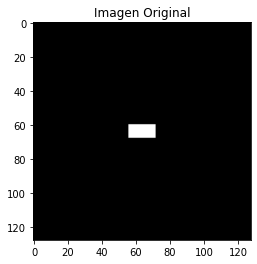

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


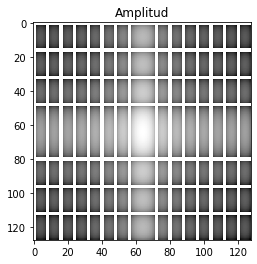

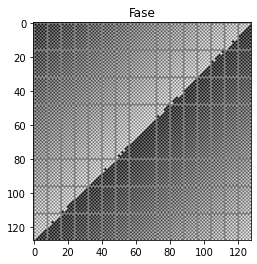

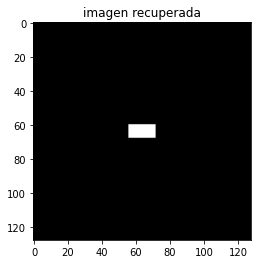

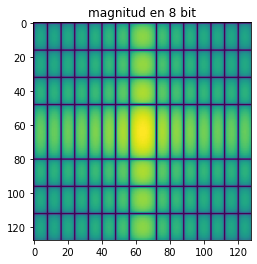

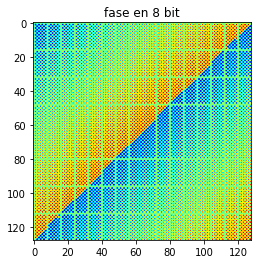

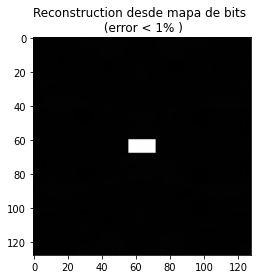

In [5]:
#@title _Cargar imagen_ seleccione la imagen a la que desea obtener el histograma y los bins del histogramarealizar la Transformada de fourier

imagen = 'block.png' #@param ['imageio:camera.png','imageio:checkerboard.png', 'imageio:coins.png','block.png' ,'circle.png' ,'circle.2.png' ,'circle.3.png' ,'circle.black.png',  'elipse.png', 'block.circle.png']
#im, im_type = load_image(imagen)
im = np.clip(imageio.imread(imagen)/255.,0.,1.)
 
plt.imshow(im,'gray')
plt.title('Imagen Original')
plt.savefig(str(imagen)+' original.png')
plt.show()

ap = fft2_ap(im)
plt.imshow(np.log(ap[0]),'gray')
plt.title('Amplitud')
plt.savefig(str(imagen)+' espectro - Amplitud.png')
plt.show()

plt.imshow(ap[1], 'gray')
plt.title('Fase')
plt.savefig(str(imagen)+' espectro - Fase.png')
plt.show()

im_back = ifft2_ap(*ap)
plt.imshow(im_back,'gray')
plt.title('imagen recuperada')
plt.savefig('Imagen recuperada (IFFT).png')
plt.show() 

amp_8bit, phase_8bit = ap_to_8bit(*fft2_ap(im))

plt.imshow(amp_8bit)
plt.title('magnitud en 8 bit')
plt.savefig(str(imagen)+' espectro - Amplitud - mapa de bits.png')
plt.show()

plt.imshow(phase_8bit,'jet')
plt.title('fase en 8 bit')
plt.savefig(str(imagen)+' espectro - Fase - mapa de bits.png')
plt.show()

im_rec = ifft2_ap(*ap_from_8bit(amp_8bit, phase_8bit))
plt.imshow(im_rec,'gray')
plt.title('Reconstruction desde mapa de bits \n (error < 1% )')
plt.savefig('Imagen recuperada (desde bitmap).png')
plt.show() 



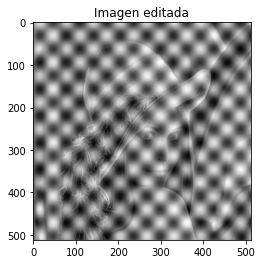

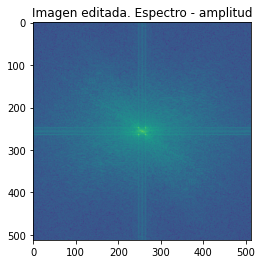

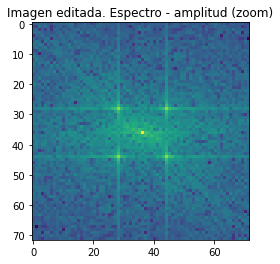

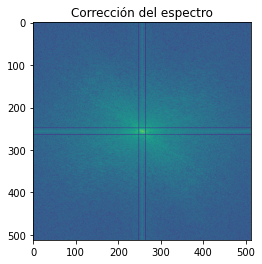

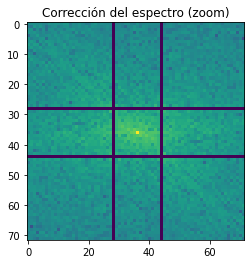

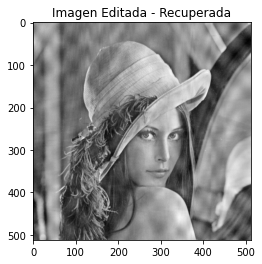

In [6]:
im_noisy = np.clip(imageio.imread('imagen.modificada.png')/255.,0.,1.)
plt.imshow(im_noisy,'gray')
plt.title('Imagen editada')
plt.savefig('noisy_image.original.png')
plt.show()
amp, phase = ap_to_8bit(*fft2_ap(im_noisy))
plt.imshow(amp)
plt.title('Imagen editada. Espectro - amplitud')
plt.savefig('noisy image. amplitud.png')
plt.show()
plt.imshow(amp[220:-220,220:-220])
plt.title('Imagen editada. Espectro - amplitud (zoom)')
plt.savefig('noisy image. amplitud (zoom).png')
plt.show()

#elimino las líneas que causan las ondas no deseadas
x1 = 248 #@param {type:"slider", min:0, max:512, step:1}
x2 = 264 #@param {type:"slider", min:0, max:512, step:1}
y1 = 248 #@param {type:"slider", min:0, max:512, step:1}
y2 = 264 #@param {type:"slider", min:0, max:512, step:1}
amp[:,y1] = 0 #248
amp[:,y2] = 0 #264
amp[x1,:] = 0 #248
amp[x2,:] = 0 #264

plt.imshow(amp)
plt.title('Corrección del espectro')
plt.savefig('noisy image. amplitud corregida.png')
plt.show()
plt.imshow(amp[220:-220,220:-220])
plt.title('Corrección del espectro (zoom)')
plt.savefig('noisy image. amplitud corregida (zoom).png')
plt.show()

# reconstruction
im_rec = ifft2_ap(*ap_from_8bit(amp,phase))
plt.imshow(im_rec,'gray')
plt.title('Imagen Editada - Recuperada')
plt.savefig('Noisy image. recuperada.png')
plt.show()

Al ingresar una imagen con cierta interferencia (en este caso ondas diagonales) se puede notar en el espectro de amplitud 4 puntos de alta energía alrededor del centro del espectro, cada par de puntos se corresponden con estas ondas diagonales. Con los cursores x1, x2 ,y1 e y2 se puede intentar elminar esta interferencia eliminando lo mejor posible estas ondas. teniendo por resultado la imagen recuperada que si bien no está 100% correcta permite interpretar mejor lo que se esta visualizando.